<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab flexure component

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

In this example we will:
* create a Landlab component that solves the two-dimensional elastic flexure equation
* apply randomly distributed point loads
* run the component
* plot some output

A bit of magic so that we can plot within this notebook.

In [2]:
%matplotlib inline
import numpy as np

## Create the grid

We are going to build a uniform rectilinear grid with a node spacing of 10 km in the *y*-direction and 20 km in the *x*-direction on which we will solve the flexure equation.

First we need to import `RasterModelGrid`.  We also import the Landlab plotting function `imshow_grid` to view the grids.

In [3]:
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid

In [1]:
n_rows = 323
n_cols = 623
dy = 20e2
dx = 20e2
filename = 'test2.asc'

In [34]:
# 此处，把n_rows,n_cols,xy_spacing改成自己的数值，。
grid = RasterModelGrid((n_rows, n_cols), xy_spacing=(dy, dx))


In [10]:
def ReadGrid(filename):
    ascii_grid = np.loadtxt(filename, skiprows=3)
    print('shape of map:',ascii_grid.shape)
    tmpmax = ascii_grid.max()
    print('max value:',tmpmax)
    ascii_grid[ascii_grid == -9999] = 0
    ascii_grid = tmpmax - ascii_grid
    ascii_grid[ascii_grid == tmpmax] = 0
    
    for i in range(int(len(ascii_grid)/2)):
        tmprow1 = ascii_grid[i].copy()
        tmprow2 = ascii_grid[len(ascii_grid)-1-i].copy()
        ascii_grid[i]=tmprow2
        ascii_grid[len(ascii_grid)-1-i]=tmprow1
    return ascii_grid

Create a rectilinear grid with a spacing of 10 km between rows and 20 km between columns. The numbers of rows and columms are provided as a `tuple` of `(n_rows, n_cols)`, in the same manner as similar numpy functions. The spacing is also a `tuple`, `(dy, dx)`.

In [6]:
grid.dy, grid.dx

(2000.0, 1000.0)

## Create the component

Now we create the flexure component and tell it to use our newly-created grid. First, though, we'll examine the `Flexure` component a bit.

In [31]:
from landlab.components.flexure import Flexure

The Flexure component, as with most landlab components, will require our grid to have some data that it will use. We can get the names of these data fields with the `intput_var_names` attribute of the component *class*.

In [24]:
Flexure.input_var_names

('lithosphere__overlying_pressure_increment',)

We see that flexure uses just one data field: the change in lithospheric loading. landlab component classes can provide additional information about each of these fields. For instance, to the the units for a field, use the `var_units` method.

In [25]:
Flexure.var_units('lithosphere__overlying_pressure_increment')

'Pa'

To print a more detailed description of a field, use `var_help`.

In [26]:
Flexure.var_help('lithosphere__overlying_pressure_increment')

name: lithosphere__overlying_pressure_increment
description:
  Applied pressure to the lithosphere over a time step
units: Pa
unit agnostic: True
at: node
intent: in


What about the data that `Flexure` provides? Use the `output_var_names` attribute.

In [27]:
Flexure.output_var_names

('lithosphere_surface__elevation_increment',)

In [28]:
Flexure.var_help('lithosphere_surface__elevation_increment')

name: lithosphere_surface__elevation_increment
description:
  The change in elevation of the top of the lithosphere (the land
  surface) in one timestep
units: m
unit agnostic: True
at: node
intent: out


Now that we understand the component a little more, create it using our grid.

In [35]:
grid.add_zeros("lithosphere__overlying_pressure_increment", at="node")
flex = Flexure(grid, method='flexure', n_procs=4,gravity =9.8,youngs =65e9,rho_mantle=3300,eet=15000)

## Add some loading
We will add loads to the grid. As we saw above, for this component, the name of the variable that holds the applied loads is `lithosphere__overlying_pressure`. We add loads of random magnitude at every node of the grid.

In [36]:
#load = np.random.normal(0, 100 * 2650. * 9.81, grid.number_of_nodes)
load = ReadGrid(filename)
grid.at_node['lithosphere__overlying_pressure_increment'] = load

shape of map: (323, 623)
max value: 4880.0


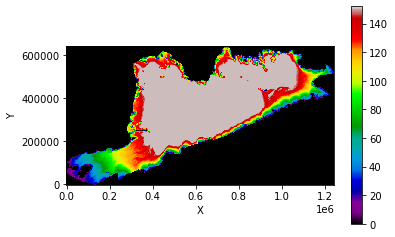

In [37]:
imshow_grid(grid,
            'lithosphere__overlying_pressure_increment',
            symmetric_cbar=False,
            cmap='nipy_spectral')

## Update the component to solve for deflection
If you have more than one processor on your machine you may want to use several of them.

In [38]:
flex.update()

As we saw above, the flexure component creates an output field (`lithosphere_surface__elevation_increment`) that contains surface deflections for the applied loads.

# Plot the output

We now plot these deflections with the `imshow_grid` method, which is available to all landlab components.

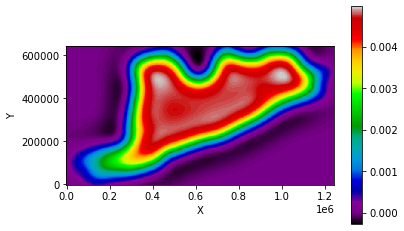

In [39]:
imshow_grid(grid,
            'lithosphere_surface__elevation_increment',
            symmetric_cbar=False,
            cmap='nipy_spectral')

Maintain the same loading distribution but double the effective elastic thickness.

In [ ]:
flex.eet *= 2.
flex.update()
imshow_grid(grid,
            'lithosphere_surface__elevation_increment',
            symmetric_cbar=True,
            cmap='nipy_spectral')

Now let's add a vertical rectangular load to the middle of the grid.  We plot the load grid first to make sure we did this correctly.

In [ ]:
load[np.where(np.logical_and(grid.node_x>3000000, grid.node_x<5000000))]= \
    load[np.where(np.logical_and(grid.node_x>3000000, grid.node_x<5000000))]+1e7
imshow_grid(grid,
            'lithosphere__overlying_pressure_increment',
            symmetric_cbar=True,
            cmap='nipy_spectral')

In [ ]:
flex.update()
imshow_grid(grid,
            'lithosphere_surface__elevation_increment',
            symmetric_cbar=True,
            cmap='nipy_spectral')

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>